In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white

In [2]:
# Load data from other notebook
gdf = pd.read_pickle('data/geodata.pkl')
df = pd.DataFrame(gdf)

In [3]:
df.columns

Index(['index', 'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'geometry',
       'dist_2_downtown', 'avg_dists'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   index            2955 non-null   int64   
 1   id               2955 non-null   int64   
 2   date             2955 non-null   object  
 3   price            2955 non-null   int64   
 4   bedrooms         2955 non-null   int64   
 5   bathrooms        2955 non-null   float64 
 6   sqft_living      2955 non-null   int64   
 7   sqft_lot         2955 non-null   int64   
 8   floors           2955 non-null   float64 
 9   waterfront       2955 non-null   float64 
 10  view             2955 non-null   float64 
 11  condition        2955 non-null   int64   
 12  grade            2955 non-null   int64   
 13  sqft_above       2955 non-null   object  
 14  sqft_basement    2955 non-null   object  
 15  yr_built         2955 non-null   int64   
 16  yr_renovated     2955 non-null   float64 


In [5]:
# Clean up the data to change strings to integers and delete unnecessary columns
df['sqft_above'] = df['sqft_above'].astype('int64')
df['sqft_basement'] = df['sqft_basement'].astype('int64')
df = df.drop(columns=['index', 'id', 'date', 'geometry'])
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            2955 non-null   int64  
 1   bedrooms         2955 non-null   int64  
 2   bathrooms        2955 non-null   float64
 3   sqft_living      2955 non-null   int64  
 4   sqft_lot         2955 non-null   int64  
 5   floors           2955 non-null   float64
 6   waterfront       2955 non-null   float64
 7   view             2955 non-null   float64
 8   condition        2955 non-null   int64  
 9   grade            2955 non-null   int64  
 10  sqft_above       2955 non-null   int64  
 11  sqft_basement    2955 non-null   int64  
 12  yr_built         2955 non-null   int64  
 13  yr_renovated     2955 non-null   float64
 14  zipcode          2955 non-null   int64  
 15  lat              2955 non-null   float64
 16  long             2955 non-null   float64
 17  sqft_living15 

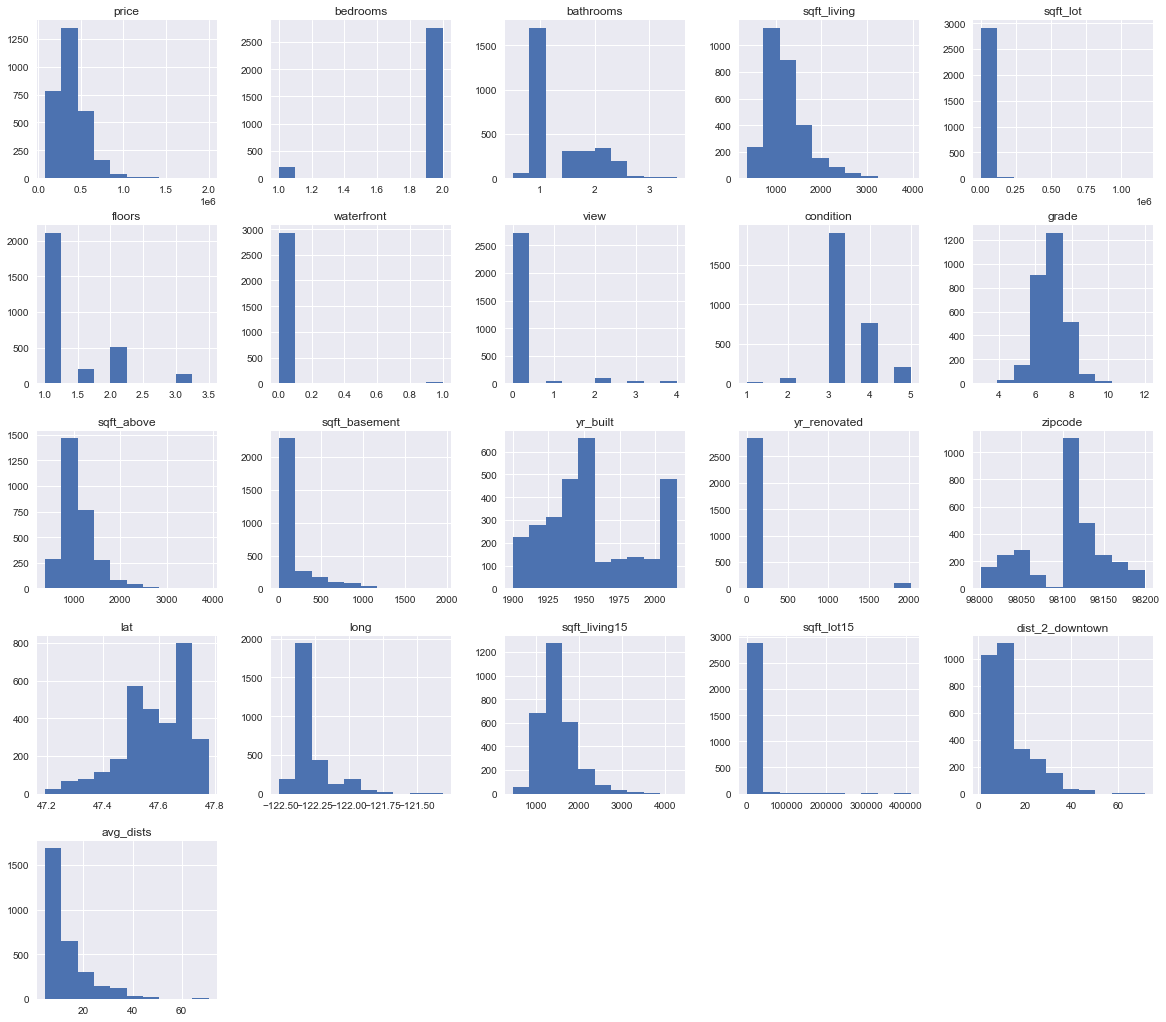

In [6]:
# Create histograms to get a sense of data
plt.style.use('seaborn')
df.hist(figsize = (20,18));

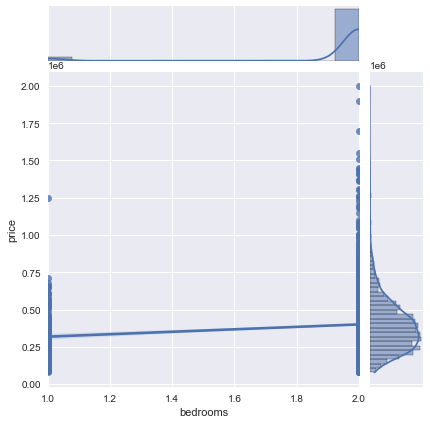

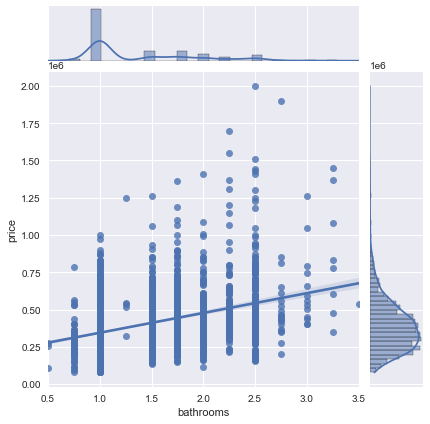

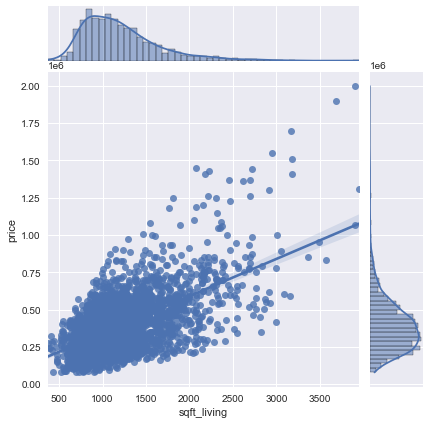

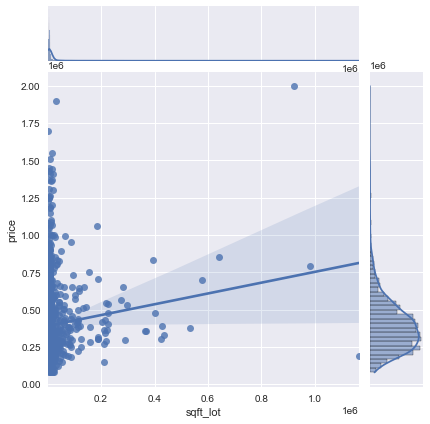

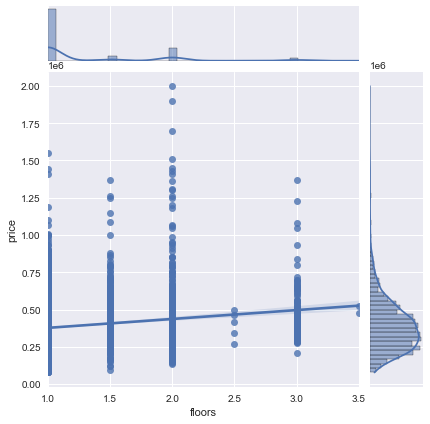

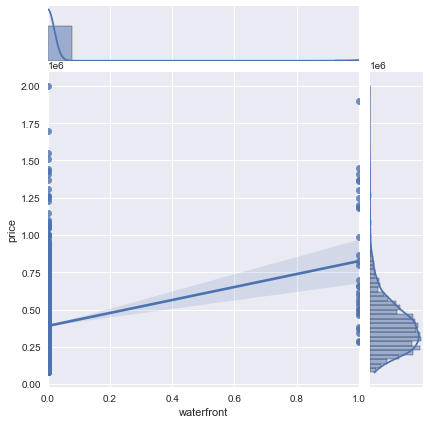

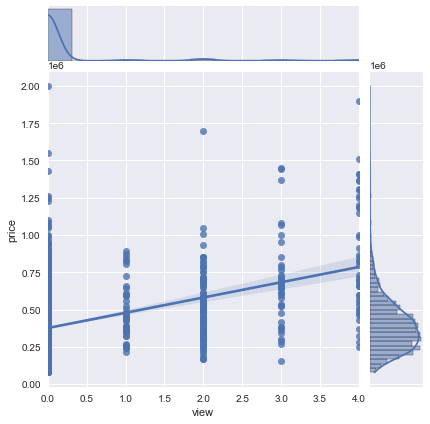

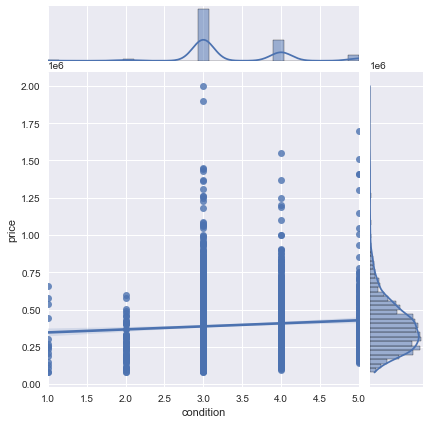

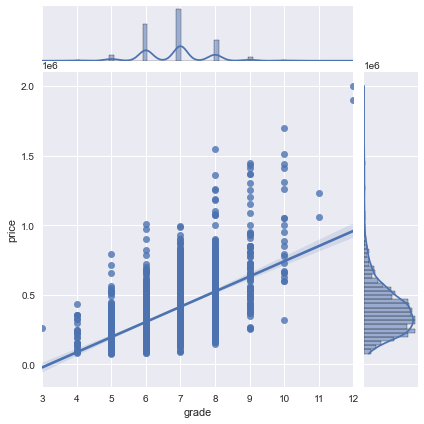

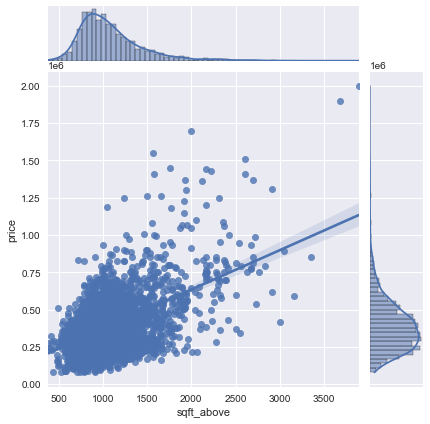

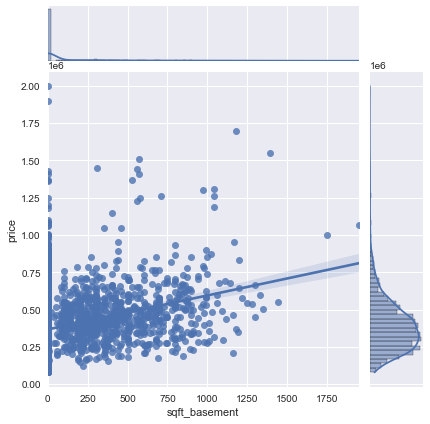

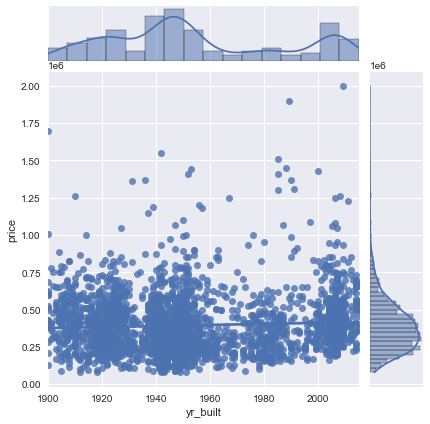

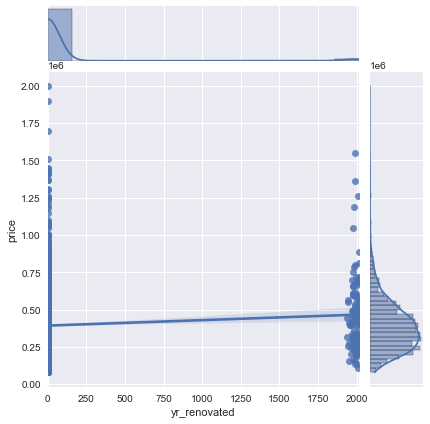

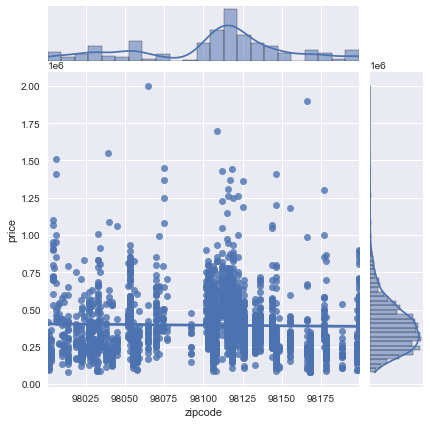

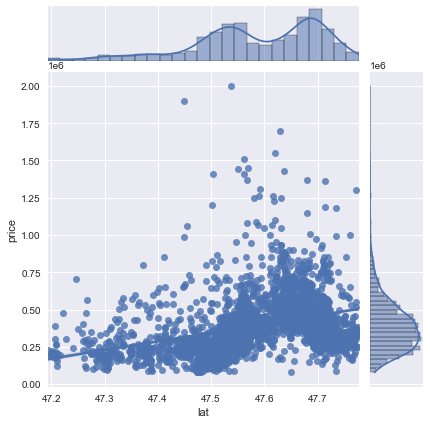

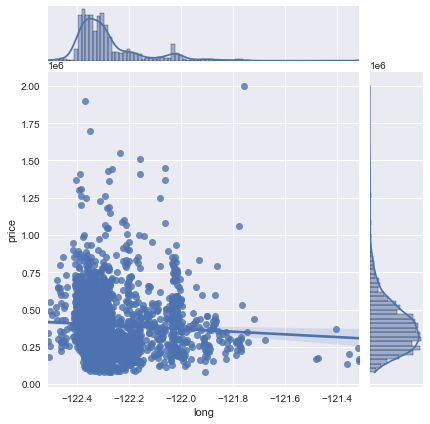

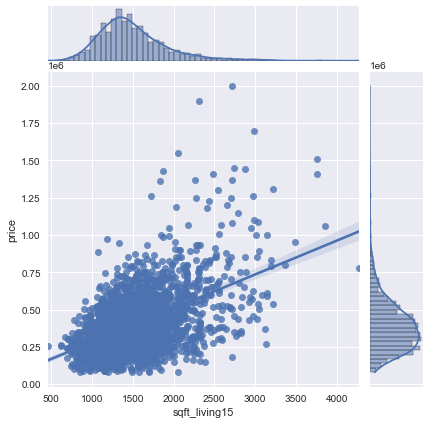

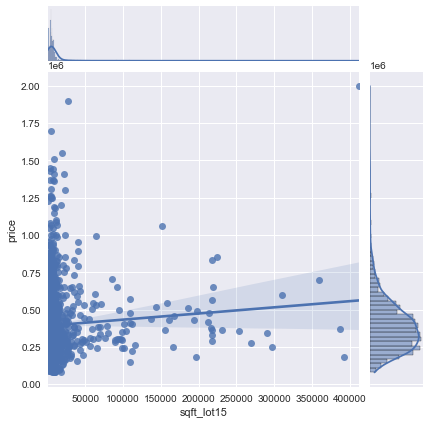

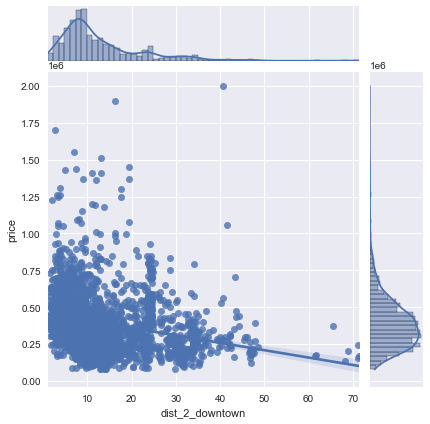

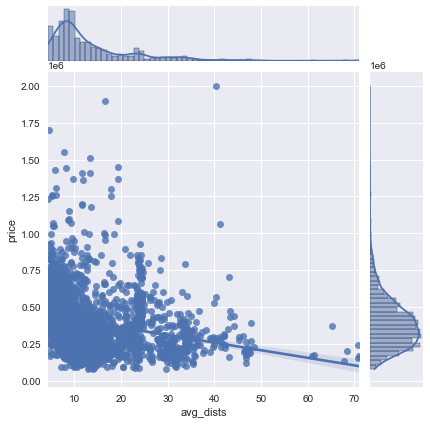

In [7]:
# look at features vs. price to get a sense what the influencers are
for col in df.columns[1:]:
    sns.jointplot(x=col, y='price', data=df, kind='reg');

<AxesSubplot:>

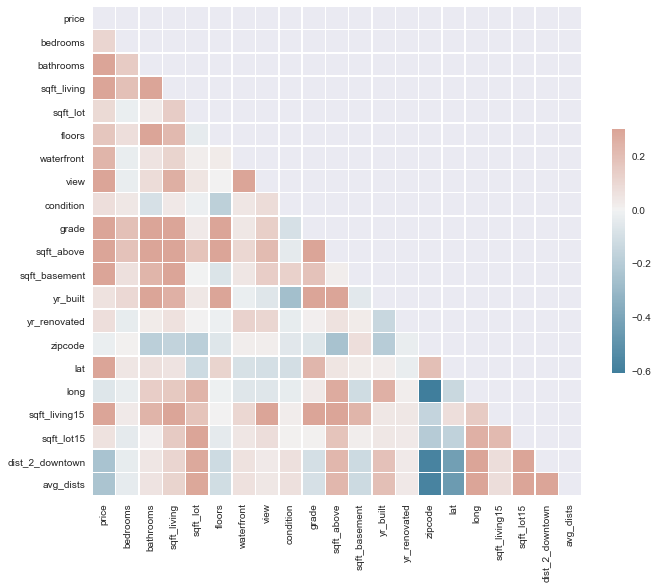

In [8]:
# Create a heatmap to identify any features with obvious multicollinearity 

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
# Drop location-related columns, leaving "dist_2_downtown"
df = df.drop(columns=['lat', 'long', 'zipcode', 'avg_dists'])

<AxesSubplot:>

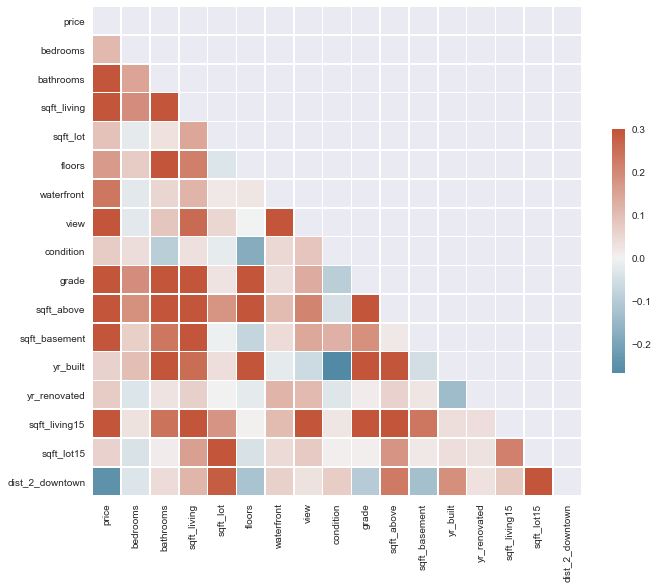

In [10]:
# Check heatmap again
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
# First Model 
outcome = 'price' # dependent variable
x_cols = df.columns[1:] # independence variables --> everything except price

# Fitting the actual model using OLS
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     295.7
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:20:21   Log-Likelihood:                -38677.
No. Observations:                2955   AIC:                         7.739e+04
Df Residuals:                    2938   BIC:                         7.749e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.337e+06   2.06e+05      6.489      0.000    9.33e+05    1.74e+06
bedrooms        -1.314e+04   8984.120     -1.463      0.144   -3.08e+04    4474.731
bathrooms        2.303e+04   6347.907      3.628      0.000    1.06e+04    3.55e+04
sqft_living       103.4111     48.982      2.111      0.035       7.368     199.454
sqft_lot            0.3042      0.058      5.261      0.000       0.191       0.418
floors          -1.306e+04   5835.589     -2.238      0.025   -2.45e+04   -1619.547
waterfront       2.113e+05   2.53e+04      8.363      0.000    1.62e+05    2.61e+05
view               3.1e+04   3988.942      7.773      0.000    2.32e+04    3.88e+04
condition        1.844e+04   3439.868      5.360      0.000    1.17e+04    2.52e+04
grade             6.21e+04   3488.501     17.800      0.000    5.53e+04    6.89e+04
sqft_above         43.9564     49.330      0.891      0.373     -52.768     140.681
sqft_basement     -23.7019     49.242     -0.481      0.630    -120.254      72.850
yr_built         -840.2863    110.017     -7.638      0.000   -1056.004    -624.568
yr_renovated        3.3867      5.929      0.571      0.568      -8.239      15.013
sqft_living15      80.5771      6.534     12.332      0.000      67.765      93.389
sqft_lot15          0.0260      0.106      0.244      0.807      -0.182       0.234
dist_2_downtown -6104.0472    292.612    -20.861      0.000   -6677.793   -5530.301
==============================================================================
Omnibus:                      417.944   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1357.399
Skew:                           0.711   Prob(JB):                    1.76e-295
Kurtosis:                       6.000   Cond. No.                     5.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# Model Refinement I

In [13]:
# Keep columns with p-value less than 0.05
outcome = 'price' # dependent variable
x_cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',  
          'grade',  'yr_built', 'sqft_living15', 'dist_2_downtown'] # independent variables

# Fitting the model again
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     422.6
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:20:21   Log-Likelihood:                -38695.
No. Observations:                2955   AIC:                         7.741e+04
Df Residuals:                    2943   BIC:                         7.749e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.394e+06   2.01e+05      6.925      0.000    9.99e+05    1.79e+06
bathrooms        2.216e+04   6343.282      3.494      0.000    9723.836    3.46e+04
floors          -5370.8367   5714.675     -0.940      0.347   -1.66e+04    5834.328
sqft_living       116.2003      7.462     15.571      0.000     101.568     130.832
sqft_lot            0.3228      0.048      6.691      0.000       0.228       0.417
waterfront       2.151e+05   2.53e+04      8.502      0.000    1.65e+05    2.65e+05
view             3.085e+04   4001.053      7.709      0.000     2.3e+04    3.87e+04
condition          1.6e+04   3416.133      4.685      0.000    9305.845    2.27e+04
grade            6.556e+04   3430.048     19.114      0.000    5.88e+04    7.23e+04
yr_built         -887.1017    107.669     -8.239      0.000   -1098.216    -675.988
sqft_living15      85.6751      6.460     13.263      0.000      73.009      98.341
dist_2_downtown -5562.1583    274.761    -20.244      0.000   -6100.901   -5023.415
==============================================================================
Omnibus:                      443.564   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1473.455
Skew:                           0.747   Prob(JB):                         0.00
Kurtosis:                       6.120   Cond. No.                     4.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# need to drop "floors" this time
outcome = 'price'
x_cols = ['bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',  
          'grade',  'yr_built', 'sqft_living15', 'dist_2_downtown']

# Fitting the model again
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     464.8
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:20:21   Log-Likelihood:                -38695.
No. Observations:                2955   AIC:                         7.741e+04
Df Residuals:                    2944   BIC:                         7.748e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.465e+06   1.86e+05      7.857      0.000     1.1e+06    1.83e+06
bathrooms        2.055e+04   6107.919      3.365      0.001    8576.850    3.25e+04
sqft_living       116.6131      7.449     15.654      0.000     102.007     131.220
sqft_lot            0.3219      0.048      6.674      0.000       0.227       0.416
waterfront       2.142e+05   2.53e+04      8.475      0.000    1.65e+05    2.64e+05
view             3.075e+04   3999.642      7.688      0.000    2.29e+04    3.86e+04
condition        1.605e+04   3415.780      4.697      0.000    9348.053    2.27e+04
grade            6.531e+04   3419.818     19.099      0.000    5.86e+04     7.2e+04
yr_built         -926.1934     99.308     -9.326      0.000   -1120.914    -731.473
sqft_living15      86.1951      6.436     13.393      0.000      73.576      98.814
dist_2_downtown -5500.2441    266.741    -20.620      0.000   -6023.262   -4977.226
==============================================================================
Omnibus:                      443.801   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1472.266
Skew:                           0.748   Prob(JB):                         0.00
Kurtosis:                       6.117   Cond. No.                     4.24e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# Model Refinement II

In [16]:
# try to normalize non-normal features via box-cox transformation
non_normal = ['sqft_living', 'sqft_lot', 'sqft_living15', 'dist_2_downtown']
for feat in non_normal:
    fitted_data, fitted_lambda = stats.boxcox(df[feat]) 
    df[feat] = fitted_data

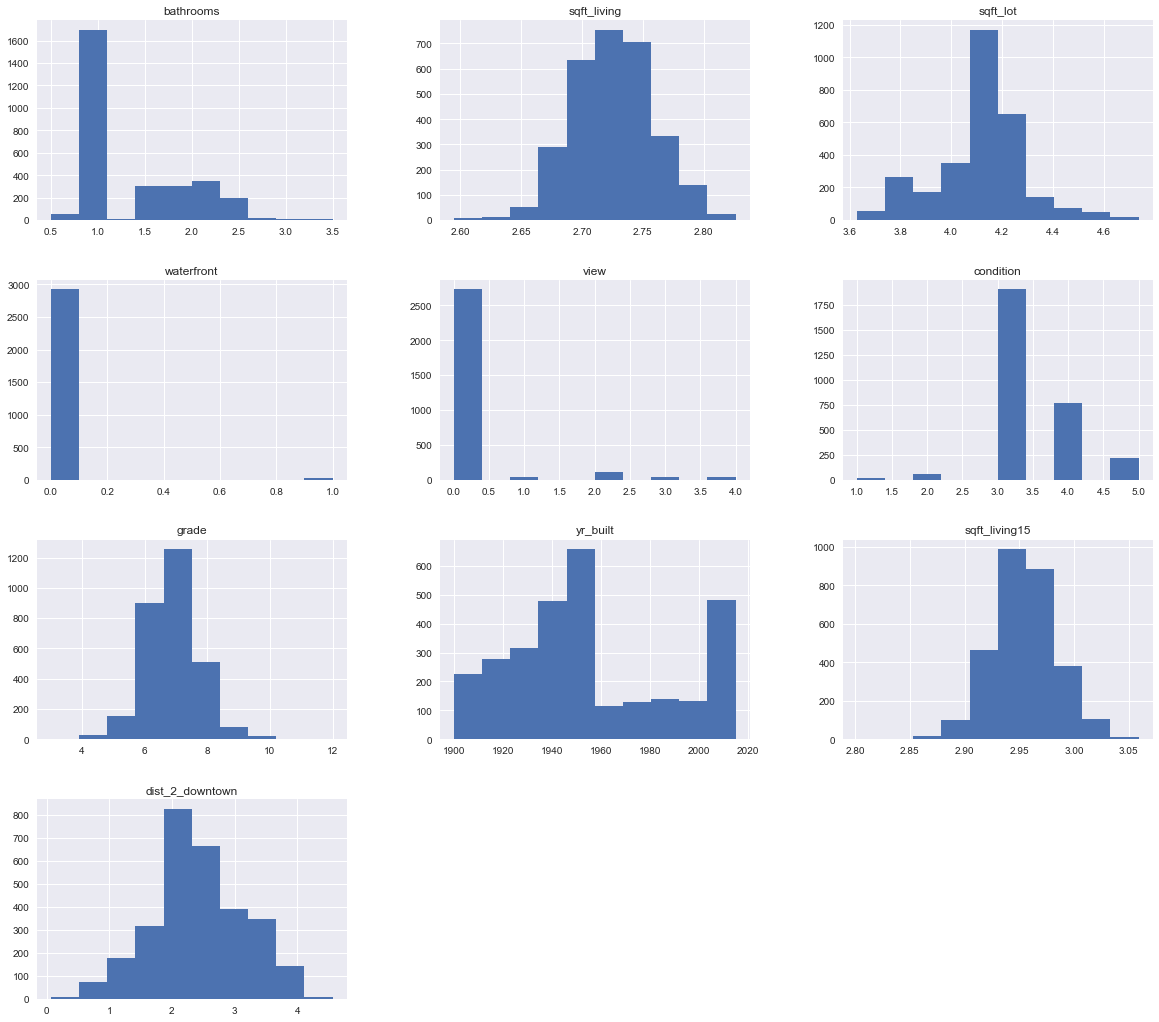

In [17]:
df[x_cols].hist(figsize = (20,18));

In [18]:
# apply the z-score method in Pandas using the .mean() and .std() methods to standardize feature values

# copy the dataframe
df_std = df.copy()
# apply the z-score method
for column in df_std.columns[1:]:
    df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
# call the z_score function
df = df_std

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,dist_2_downtown
0,180000,0.266489,-0.710840,-1.181480,0.718742,-0.559158,-0.102948,-0.265218,-0.552444,-0.847153,-0.848300,-0.491506,-0.667913,-0.197517,2.230396,-0.072090,0.587592
1,468000,0.266489,-0.710840,0.101969,0.213819,-0.559158,-0.102948,-0.265218,0.937038,0.184725,-0.607852,0.699431,-0.388838,-0.197517,-0.286180,-0.149607,-0.167800
2,189000,0.266489,-0.710840,0.200557,0.704524,-0.559158,-0.102948,-0.265218,0.937038,0.184725,0.300505,-0.491506,-1.040014,-0.197517,-1.204073,-0.183629,1.670518
3,252700,0.266489,0.223353,-0.137394,0.684471,-0.559158,-0.102948,-0.265218,-0.552444,0.184725,-0.046808,-0.491506,0.944523,-0.197517,-0.628041,-0.059909,1.506482
4,280000,0.266489,0.223353,0.176324,-1.680763,3.217554,-0.102948,-0.265218,-0.552444,0.184725,0.273788,-0.491506,1.564691,-0.197517,-0.114838,-0.309154,0.302622


In [19]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     432.0
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:20:25   Log-Likelihood:                -38760.
No. Observations:                2955   AIC:                         7.754e+04
Df Residuals:                    2944   BIC:                         7.761e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.949e+05   2217.510    178.082      0.000    3.91e+05    3.99e+05
bathrooms        2.192e+04   3387.758      6.470      0.000    1.53e+04    2.86e+04
sqft_living      3.461e+04   3468.175      9.979      0.000    2.78e+04    4.14e+04
sqft_lot         2.382e+04   3371.442      7.066      0.000    1.72e+04    3.04e+04
waterfront       2.194e+04   2635.704      8.323      0.000    1.68e+04    2.71e+04
view             2.566e+04   2761.292      9.293      0.000    2.02e+04    3.11e+04
condition        1.252e+04   2349.203      5.331      0.000    7918.043    1.71e+04
grade            6.889e+04   3502.283     19.670      0.000     6.2e+04    7.58e+04
yr_built        -2.624e+04   3429.447     -7.651      0.000    -3.3e+04   -1.95e+04
sqft_living15    3.504e+04   2748.651     12.746      0.000    2.96e+04    4.04e+04
dist_2_downtown -5.956e+04   3024.921    -19.689      0.000   -6.55e+04   -5.36e+04
==============================================================================
Omnibus:                      697.588   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3672.559
Skew:                           1.021   Prob(JB):                         0.00
Kurtosis:                       8.066   Cond. No.                         3.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Check for Multicollinearity --> want values < 5
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bathrooms', 2.3331711075842216),
 ('sqft_living', 2.4452529458139556),
 ('sqft_lot', 2.310751070598459),
 ('waterfront', 1.4122615457086722),
 ('view', 1.5500528196723031),
 ('condition', 1.121922584916998),
 ('grade', 2.493585654708853),
 ('yr_built', 2.3909466330742304),
 ('sqft_living15', 1.5358924009528285),
 ('dist_2_downtown', 1.8601581291023606)]

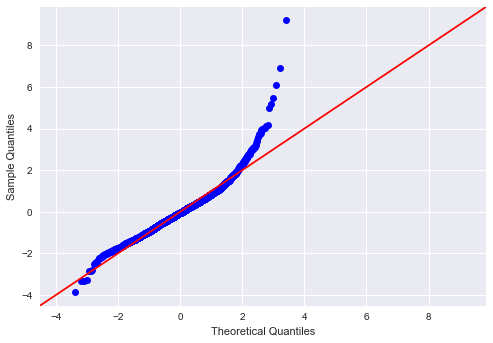

In [21]:
# Q-Q Plot to check normality of residuals
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

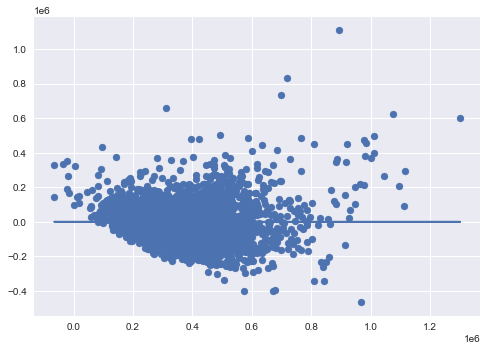

In [22]:
# Checking for Homoscedasticity
plt.scatter(model.predict(df[x_cols]), model.resid)
plt.plot(model.predict(df[x_cols]), [0 for i in range(len(df))])

In [23]:
white_test = het_white(model.resid,  model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 843.6138158612542, 'LM-Test p-value': 2.0330769244865813e-136, 'F-Statistic': 18.042382136749584, 'F-Test p-value': 2.4026181255544216e-164}


In [24]:
# Model Refinement III
# Try to address residual normality issues with residuals and heteroscedasticity

In [25]:
# Finding a cutoff point to narrow the price range
for i in range(0, 20):
    q = i / 100
    print('{} percentile: {}'.format(q, df['price'].quantile(q=q)))

print('---')
    
for i in range(80, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, df['price'].quantile(q=q)))

0.0 percentile: 78000.0
0.01 percentile: 109270.0
0.02 percentile: 124540.0
0.03 percentile: 144990.5
0.04 percentile: 155000.0
0.05 percentile: 163710.0
0.06 percentile: 174120.0
0.07 percentile: 179989.0
0.08 percentile: 187524.0
0.09 percentile: 192500.0
0.1 percentile: 199950.0
0.11 percentile: 202000.0
0.12 percentile: 208408.16
0.13 percentile: 212000.0
0.14 percentile: 216500.0
0.15 percentile: 220754.99999999997
0.16 percentile: 226512.0
0.17 percentile: 230000.0
0.18 percentile: 235000.0
0.19 percentile: 239950.0
---
0.8 percentile: 515000.0
0.81 percentile: 525000.0
0.82 percentile: 530000.0
0.83 percentile: 540000.0
0.84 percentile: 549000.0
0.85 percentile: 553000.0
0.86 percentile: 563160.0000000001
0.87 percentile: 575000.0
0.88 percentile: 582260.0
0.89 percentile: 599057.0
0.9 percentile: 605075.0
0.91 percentile: 626129.9999999994
0.92 percentile: 650000.0
0.93 percentile: 665000.0
0.94 percentile: 695000.0
0.95 percentile: 716499.9999999986
0.96 percentile: 751469.999

In [26]:
# Keep values between 1% and 90%
lower = 109270
upper = 605075

subset = df[(df['price'] >= lower) & (df['price'] <= upper)].reset_index()
# subset = df[(df['price'] <= 716500)].reset_index()
print('Percent removed:',(len(df) - len(subset))/len(df))

x_cols = ['bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',  
          'grade',  'yr_built', 'sqft_living15', 'dist_2_downtown']

# subset['price'] = subset['price'].map(np.log)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=subset).fit()
model.summary()

Percent removed: 0.11032148900169204


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     217.0
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:20:26   Log-Likelihood:                -33685.
No. Observations:                2629   AIC:                         6.739e+04
Df Residuals:                    2618   BIC:                         6.746e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.676e+05   1776.923    206.853      0.000    3.64e+05    3.71e+05
bathrooms        1.142e+04   2720.917      4.196      0.000    6080.953    1.68e+04
sqft_living       2.46e+04   2723.881      9.033      0.000    1.93e+04    2.99e+04
sqft_lot         6121.7239   2712.241      2.257      0.024     803.370    1.14e+04
waterfront       1.196e+04   2942.956      4.064      0.000    6189.348    1.77e+04
view             4579.5783   2837.389      1.614      0.107    -984.174    1.01e+04
condition        9304.3823   1859.004      5.005      0.000    5659.116    1.29e+04
grade            4.383e+04   2890.543     15.163      0.000    3.82e+04    4.95e+04
yr_built        -2.115e+04   2712.111     -7.799      0.000   -2.65e+04   -1.58e+04
sqft_living15     2.56e+04   2149.979     11.909      0.000    2.14e+04    2.98e+04
dist_2_downtown -4.614e+04   2367.782    -19.486      0.000   -5.08e+04   -4.15e+04
==============================================================================
Omnibus:                       11.499   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.633
Skew:                           0.161   Prob(JB):                      0.00298
Kurtosis:                       2.951   Cond. No.                         3.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

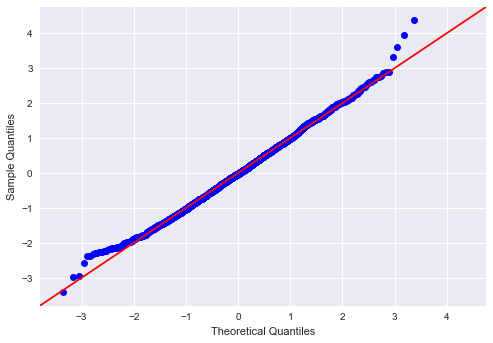

In [27]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

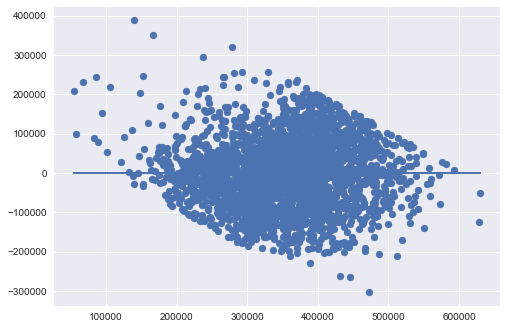

In [28]:
plt.scatter(model.predict(subset[x_cols]), model.resid)
plt.plot(model.predict(subset[x_cols]), [0 for i in range(len(subset))])

In [29]:
white_test = het_white(model.resid,  model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 258.62314411936086, 'LM-Test p-value': 3.1923664232831146e-25, 'F-Statistic': 4.371072762365693, 'F-Test p-value': 6.719126317751455e-27}


In [30]:
# Model Refinement IV
# Residual normality improved but still not homoscedastic
# Try building a model from the ground up

In [31]:
outcome = 'price'

# x_cols = ['bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition',  
#           'grade',  'yr_built', 'sqft_living15', 'dist_2_downtown']

x_cols = ['grade', 'sqft_living', 'dist_2_downtown', 'waterfront']
subset = df[(df['price'] >= lower) & (df['price'] <= upper)].reset_index()
print('Percent removed:',(len(df) - len(subset))/len(df))
# subset['price'] = subset['price'].map(np.log)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=subset).fit()
model.summary()

Percent removed: 0.11032148900169204


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     399.0
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          9.60e-269
Time:                        22:20:27   Log-Likelihood:                -33854.
No. Observations:                2629   AIC:                         6.772e+04
Df Residuals:                    2624   BIC:                         6.775e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.642e+05   1873.671    194.367      0.000    3.61e+05    3.68e+05
grade             2.84e+04   2533.560     11.210      0.000    2.34e+04    3.34e+04
sqft_living      4.358e+04   2470.423     17.639      0.000    3.87e+04    4.84e+04
dist_2_downtown -4.678e+04   1946.414    -24.033      0.000   -5.06e+04    -4.3e+04
waterfront       1.651e+04   2694.059      6.128      0.000    1.12e+04    2.18e+04
==============================================================================
Omnibus:                       36.631   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.449
Skew:                           0.242   Prob(JB):                     3.31e-08
Kurtosis:                       2.718   Cond. No.                         2.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

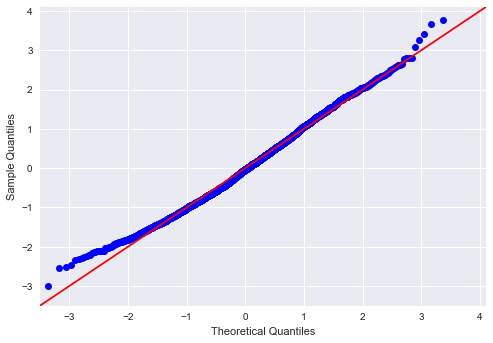

In [32]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

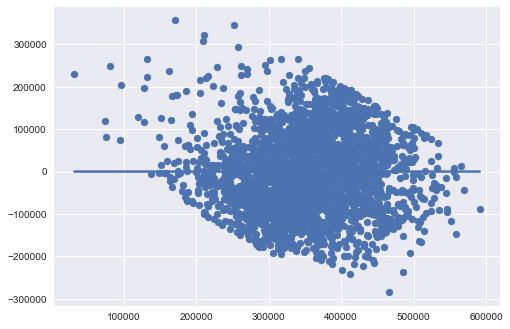

In [33]:
plt.scatter(model.predict(subset[x_cols]), model.resid)
plt.plot(model.predict(subset[x_cols]), [0 for i in range(len(subset))])

In [ ]:
white_test = het_white(model.resid,  model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))